## **Part 2: A Continuous-Time Model**

In [26]:
# Plotting
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import plotly.io as pio
import matplotlib.pyplot as plt
#pio.renderers.default = "notebook+pdf"
#pio.templates.default = "plotly_dark"

# Utilities
import numpy as np
import scipy.linalg as la

### **Task 7**

In [113]:
Q = np.array([
    [-0.0085, 0.005, 0.0025, 0, 0.001],
    [0, -0.014, 0.005, 0.004, 0.005],
    [0, 0, -0.008, 0.003, 0.005],
    [0, 0, 0, -0.009, 0.009],
    [0, 0, 0, 0, 0]
])
Qs = Q[:-1, :-1]
Qdiag = np.diag(Q)
stateDescs = ['Starting State', 'Local Recurrence', 'Distant Metastasis', 'Both Local and Distant', 'Death']

def changeState(Q, state, currentTime, endTime):
    if state == 4:
        return endTime, 4
    qii = Q[state,state]
    if qii == 0:
        return endTime, state
    time = np.random.exponential(-(1/qii))
    if currentTime + time > endTime:
        return endTime, state
    # Determine the next state
    ps = np.copy(Q[state, :])
    ps[state] = 0
    ps /= -qii
    ps[state] = 1 - sum(ps)
    nextState = np.random.choice(range(5), p=ps)
    return time, nextState

def simulateWoman(Q, startingState, endTime):
    state = startingState
    time = 0
    times = [0]
    states = [state]
    while state != 4 and time < endTime:
        dt, state = changeState(Q, state, time, endTime)
        time += dt
        times.append(time)
        states.append(state)
    return np.array(times), np.array(states)

def simulateWomen(Q, n, startingStates, endTime):
    women = []
    for i in range(n):
        times, states = simulateWoman(Q, startingStates[i], endTime)
        women.append((times, states))
    return women




#### **Analyzing state distribution after 30.5 months**

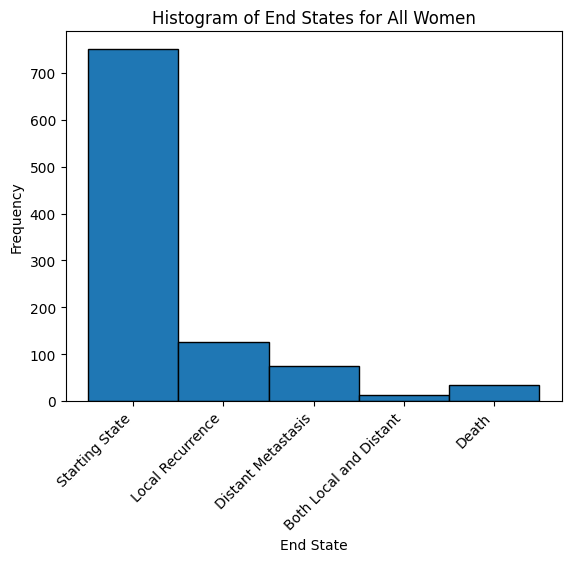

8.799999999999999% of women had a distant reappearence of breast cancer


In [114]:
n = 1000
endTime = 30.5
startingStates = np.zeros(n, dtype=int)
womenTask7 = simulateWomen(Q, n, startingStates, endTime)

# Make histogram of end states for all women
endStates = np.array([woman[1][-1] for woman in womenTask7], dtype=int)
plt.hist(endStates, bins=np.arange(0,6), edgecolor='black')
plt.title('Histogram of End States for All Women')
plt.xlabel('End State')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(0, 5)+0.5, labels=stateDescs, rotation=45, ha="right")
plt.show()

histogram = np.histogram(endStates, bins=np.arange(0,6))[0]
print(f"{(histogram[2] + histogram[3]) / n * 100}% of women had a distant reappearence of breast cancer")

#### **Summary of liftime distribution after surgery**

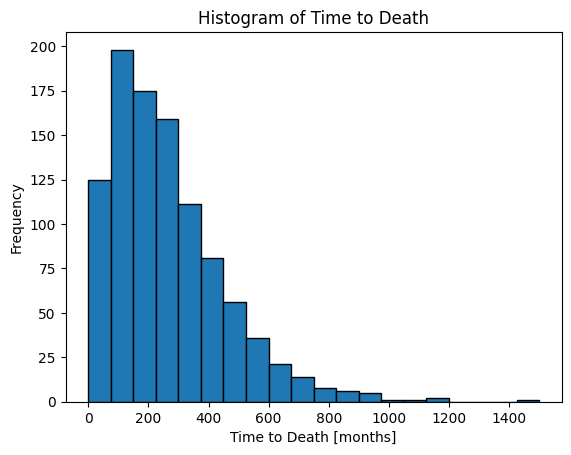

In [115]:
n = 1000
endTime = np.inf
startingStates = np.zeros(n, dtype=int)
women = simulateWomen(Q, n, startingStates, endTime)

# Time histogram
times = np.array([woman[0][-1] for woman in women], dtype=int)
plt.hist(times, bins=20, edgecolor='black')
plt.title('Histogram of Time to Death')
plt.xlabel('Time to Death [months]')
plt.ylabel('Frequency')
plt.show()

#### **Getting a mean lifetime after surgery**

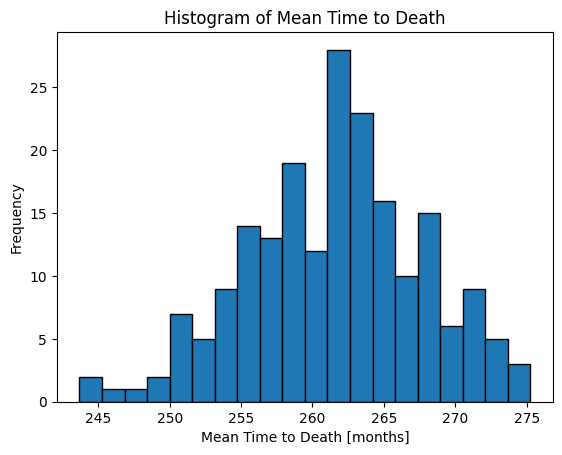

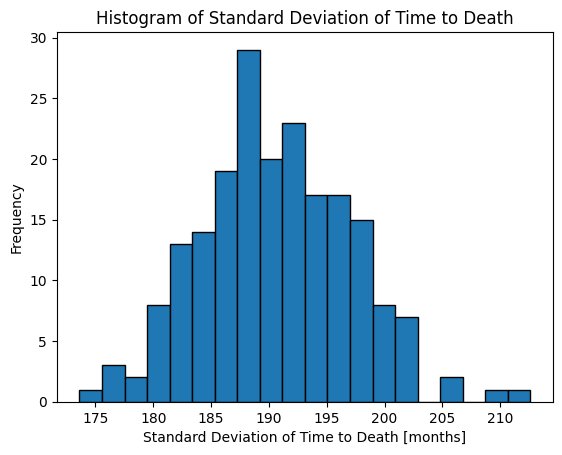

In [116]:
m = 200
means = []
sds = []
for i in range(m):
    women = simulateWomen(Q, n, startingStates, endTime)
    times = np.array([woman[0][-1] for woman in women], dtype=int)
    means.append(np.mean(times))
    sds.append(np.std(times))
plt.hist(means, bins=20, edgecolor='black')[0]
plt.title('Histogram of Mean Time to Death')
plt.xlabel('Mean Time to Death [months]')
plt.ylabel('Frequency')
plt.show()

plt.hist(sds, bins=20, edgecolor='black')
plt.title('Histogram of Standard Deviation of Time to Death')
plt.xlabel('Standard Deviation of Time to Death [months]')
plt.ylabel('Frequency')
plt.show()

In [77]:
print(f"Mean time to death: {round(np.mean(means),1)} months")
print(f"95% confidence interval for mean lifetime: {np.percentile(means, [2.5, 97.5])}")
print(f"Mean standard deviation of time to death: {round(np.mean(sds),1)} months")
print(f"95% confidence interval for standard deviation of lifetime: {np.percentile(sds, [2.5, 97.5])}")

Mean time to death: 261.7 months
95% confidence interval for mean lifetime: [252.224    272.074625]
Mean standard deviation of time to death: 190.8 months
95% confidence interval for standard deviation of lifetime: [180.65541071 203.50467002]


### **Task 8**
Compare the emperical lifetime distribution function, from your simulations,
to the theoretical, using an appropriate statistical test.

In [108]:
# Theretical lifetime distribution
def Ft(t, p0):
    F = 1 - p0 @ la.expm(Qs * t) @ np.ones(4)
    return F

endTime = np.inf
n = 1000
startingStates = np.zeros(n, dtype=int)
women = simulateWomen(Q, n, startingStates, endTime)
p0 = np.array([1, 0, 0, 0])

# KS test
deathTimes = []
for w in women:
    deathTimes.append(w[0][-1])

deathTimes = np.array(deathTimes)
deathTimes = np.sort(deathTimes)
# get the empirical CDF
n = len(deathTimes)
Fs = np.arange(1, n+1) / n
# Theoretical CDF
FsTrue= []
for t in deathTimes:
    FsTrue.append(Ft(t, p0))
FsTrue = np.array(FsTrue)

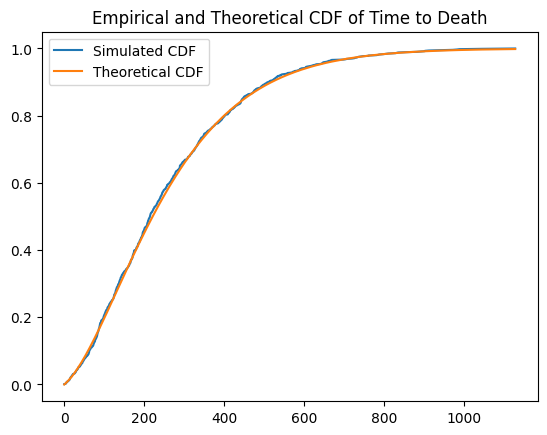

KS test statistic: 0.019924597984353087
p-value: 0.5479575599655682


In [111]:
plt.plot(deathTimes, Fs, label='Empirical CDF')
plt.plot(deathTimes, FsTrue, label='Theoretical CDF')
plt.legend(['Simulated CDF', 'Theoretical CDF'])
plt.title('Empirical and Theoretical CDF of Time to Death')
plt.show()

# KS test
D = np.max(np.abs(Fs - FsTrue))
print(f"KS test statistic: {D}")
pval = 1 - np.exp(-2*n*D**2)
print(f"p-value: {pval}")

### **Task 9**

In [117]:
QTreat = np.array([
    [-0.00475,0.0025, 0.00125, 0, 0.001],
    [0, -0.007,0 , 0.002, 0.005],
    [0, 0, -0.008 , 0.003, 0.005],
    [0, 0, 0, -0.009, 0.009],
    [0, 0, 0, 0, 0]
])

womenTreat = simulateWomen(QTreat, n, startingStates, endTime)


### **Task 10**

### **Task 11**